In [8]:
try:
    spark.stop()
except:
    pass

In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

spark = SparkSession.builder \
    .appName("APP_2") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True)
])
# Read ratings.csv
df = spark.read.csv("ratings.csv", header=True, schema = schema).cache()

In [35]:
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

Rows: 32000204
Unique users: 200948
Unique Movies: 84432


In [36]:
# Select first n unique users
unique_users = df.select("userId").distinct().limit(1500)

# Keep only rows from these users
df = df.join(unique_users, on="userId", how="inner")

df.show(5)
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    28|      1|   4.0|
|    28|      2|   3.0|
|    28|      3|   4.0|
|    28|      5|   2.0|
|    28|      6|   3.0|
+------+-------+------+
only showing top 5 rows
Rows: 233463
Unique users: 1500
Unique Movies: 13435


In [37]:
n_users = df.select("userId").distinct().count()
n_movies = df.select("movieId").distinct().count()
n_ratings = df.count()

sparsity = (n_ratings / (n_users * n_movies)) * 100
print(f"Sparsity: {sparsity:.4f}%")

Sparsity: 1.1585%


In [38]:
from pyspark.sql.functions import col, round as spark_round
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

user_indexer = StringIndexer(inputCol="userId", outputCol="user")
movie_indexer = StringIndexer(inputCol="movieId", outputCol="movie")
assembler = VectorAssembler(inputCols=["rating"], outputCol="rating_vec")
scaler = MinMaxScaler(inputCol="rating_vec", outputCol="rating_scaled")

pipeline = Pipeline(stages=[user_indexer, movie_indexer, assembler, scaler])

pipeline_model = pipeline.fit(df)
scaled_df = pipeline_model.transform(df)

# Flatten vector -> float, then round to 1 decimal
scaled_df = scaled_df.withColumn(
    "rating_scaled",
    spark_round(vector_to_array(col("rating_scaled"))[0], 1)
)

# Keep only necessary columns
df_final = scaled_df.select("user", "movie", "rating_scaled")
df_final = df_final.cache()
df_final.show(5)

+----+-----+-------------+
|user|movie|rating_scaled|
+----+-----+-------------+
| 1.0| 10.0|          0.8|
| 1.0|147.0|          0.6|
| 1.0|522.0|          0.8|
| 1.0|454.0|          0.3|
| 1.0|141.0|          0.6|
+----+-----+-------------+
only showing top 5 rows


In [39]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [40]:
import torch

# 80% train, 20% test
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

#Converting PySpark DF to Pandas to Tensors
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

X_train = torch.tensor(train_pd[["user", "movie"]].values)
y_train = torch.tensor(train_pd["rating_scaled"].values)

X_test = torch.tensor(test_pd[["user", "movie"]].values)
y_test = torch.tensor(test_pd["rating_scaled"].values)

print("Train count:", X_train.shape[0])
print("Train Label:",y_train.shape[0])
print("Test count:", X_test.shape[0])
print("Test Label:",y_test.shape[0])

Train count: 186513
Train Label: 186513
Test count: 46950
Test Label: 46950


In [41]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#print(train_dataset[2200])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim, hidden, dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)   
        self.movie_emb = nn.Embedding(n_movies, emb_dim)  
        self.dropout_emb = 0.4

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden), 
            nn.BatchNorm1d(hidden),  
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),  
            nn.Sigmoid()  
        )

    def forward(self,user,movie):
        u = F.dropout(self.user_emb(user), p=self.dropout_emb, training=self.training)
        m = F.dropout(self.movie_emb(movie), p=self.dropout_emb, training=self.training)
        
        # Concatenate embeddings (instead of dot product)
        x = torch.cat([u, m], dim=1)
        
        # Pass through MLP
        return self.mlp(x).squeeze()


In [43]:
loss_fn = nn.MSELoss()

In [44]:
def adam(parameter, m_state, v_state, t, lr=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # Loop over Tensors in model.parameters()
    for p in parameter:
        if p.grad is None:
            continue

        # First Time seeing this parameter
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)

        g = p.grad
        # First moment
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        # Second moment
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)

        # Bias correction
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)

        # Parameter update (in-place)
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)

    return m_state, v_state


In [45]:
epochs = 10
n_models = 10
all_result = []

n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

for i in range(1, n_models + 1):
    print(f"\n================ Training Model {i}/{n_models} ================")

    model = CollabFiltering(
        n_users_global, n_movies_global, emb_dim=32, hidden=64, dropout=0.03
    )
    m_state, v_state = {}, {}
    t = 0

    best_rmse = float("inf")
    best_state = None
    best_epoch = -1

    train_losses, test_losses = [], []
    train_rmses, test_rmses = [], []

    for epoch in range(epochs):
        # ---------- Training ----------
        model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0

        for X_batch, y_batch in train_loader:
            user_batch = X_batch[:, 0].long()
            movie_batch = X_batch[:, 1].long()

            preds = model(user_batch, movie_batch).squeeze()
            loss = loss_fn(preds, y_batch.float())

            model.zero_grad()
            loss.backward()

            # Custom Adam
            t += 1
            m_state, v_state = adam(model.parameters(), m_state, v_state, t)

            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5
        train_losses.append(train_loss)
        train_rmses.append(train_rmse)

        # ---------- Testing ----------
        model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                user_batch = X_batch[:, 0].long()
                movie_batch = X_batch[:, 1].long()

                preds = model(user_batch, movie_batch).squeeze()
                loss = loss_fn(preds, y_batch.float())

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5
        test_losses.append(test_loss)
        test_rmses.append(test_rmse)

        # ---------- Checkpoint ----------
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch + 1
            best_state = model.state_dict()

    # ---------------- After Training: restore best checkpoint ----------------
    print(f"\nBest checkpoint for Model {i} was at Epoch {best_epoch} with Test RMSE = {best_rmse:.4f}")
    model.load_state_dict(best_state)

    # ---------- Capture gradients at best checkpoint ----------
    model.train()
    X_batch, y_batch = next(iter(train_loader))  # one batch is enough
    user_batch = X_batch[:, 0].long()
    movie_batch = X_batch[:, 1].long()

    preds = model(user_batch, movie_batch).squeeze()
    loss = loss_fn(preds, y_batch.float())

    model.zero_grad()
    loss.backward()

    print(f"\nGradients at best checkpoint (Model {i}):")
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name}: mean={param.grad.mean().item():.6f}, std={param.grad.std().item():.6f}")

    # Save results
    all_result.append({
        "model": i,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_rmses": train_rmses,
        "test_rmses": test_rmses,
        "best_epoch": best_epoch,
        "best_rmse": best_rmse
    })



================ Training Model 1/10 ================

Best checkpoint for Model 1 was at Epoch 10 with Test RMSE = 0.1971

Gradients at best checkpoint (Model 1):
user_emb.weight: mean=-0.000000, std=0.000001
movie_emb.weight: mean=-0.000000, std=0.000000
mlp.0.weight: mean=0.000000, std=0.000003
mlp.0.bias: mean=0.000000, std=0.000000
mlp.1.weight: mean=0.000070, std=0.000399
mlp.1.bias: mean=0.000159, std=0.001112
mlp.4.weight: mean=0.000354, std=0.002158
mlp.4.bias: mean=0.005326, std=nan

================ Training Model 2/10 ================


C:\Users\GOUTHAM\AppData\Local\Temp\ipykernel_16012\2620873639.py:97: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  print(f"{name}: mean={param.grad.mean().item():.6f}, std={param.grad.std().item():.6f}")



Best checkpoint for Model 2 was at Epoch 5 with Test RMSE = 0.2001

Gradients at best checkpoint (Model 2):
user_emb.weight: mean=0.000000, std=0.000000
movie_emb.weight: mean=-0.000000, std=0.000000
mlp.0.weight: mean=0.000000, std=0.000001
mlp.0.bias: mean=0.000000, std=0.000000
mlp.1.weight: mean=0.000094, std=0.000756
mlp.1.bias: mean=-0.000008, std=0.000064
mlp.4.weight: mean=0.000088, std=0.000701
mlp.4.bias: mean=0.004714, std=nan

================ Training Model 3/10 ================

Best checkpoint for Model 3 was at Epoch 9 with Test RMSE = 0.1977

Gradients at best checkpoint (Model 3):
user_emb.weight: mean=-0.000000, std=0.000001
movie_emb.weight: mean=0.000000, std=0.000000
mlp.0.weight: mean=-0.000000, std=0.000002
mlp.0.bias: mean=0.000000, std=0.000000
mlp.1.weight: mean=-0.000084, std=0.000533
mlp.1.bias: mean=0.000159, std=0.000919
mlp.4.weight: mean=0.000153, std=0.000858
mlp.4.bias: mean=0.012137, std=nan

================ Training Model 4/10 ================

Be

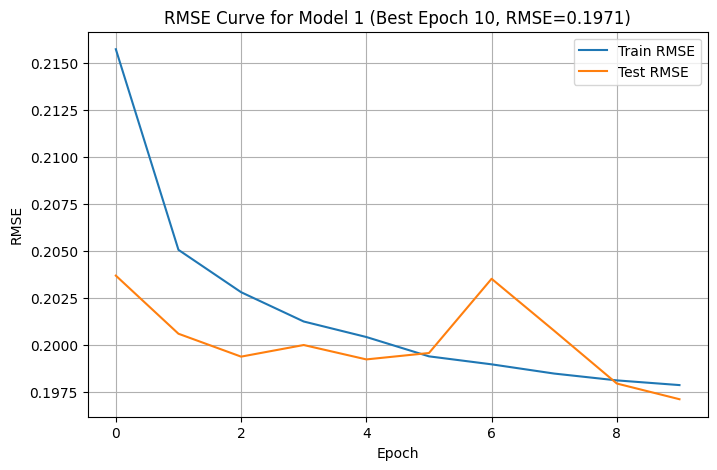

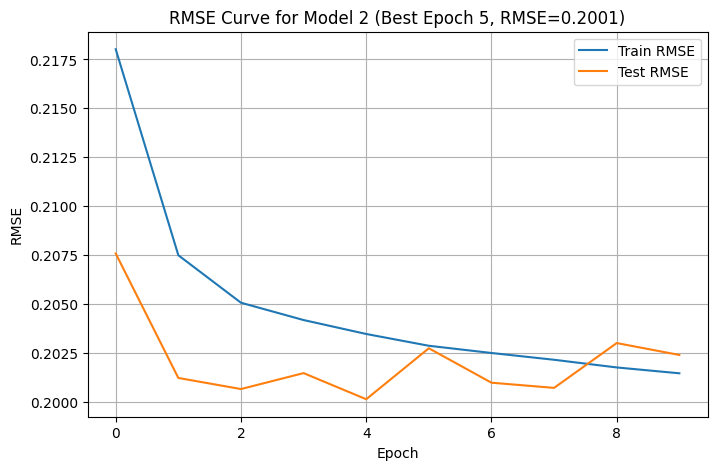

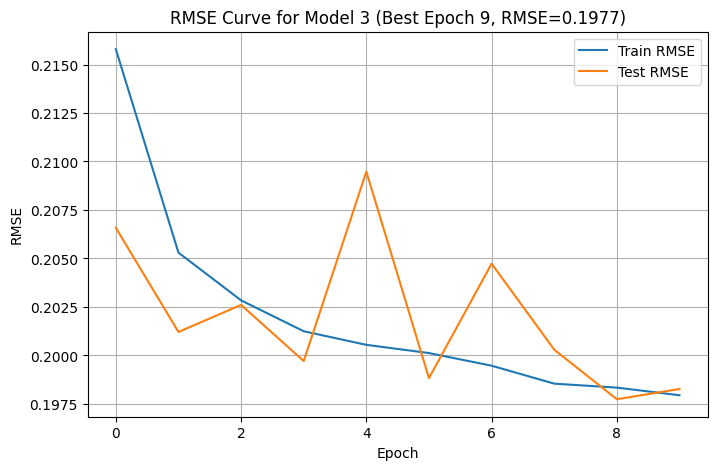

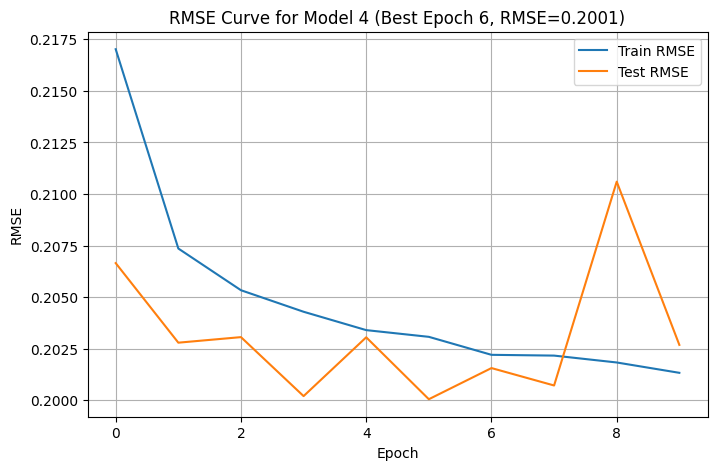

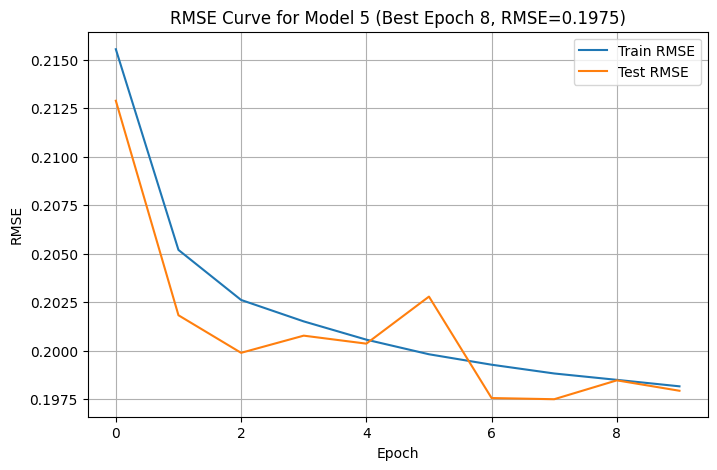

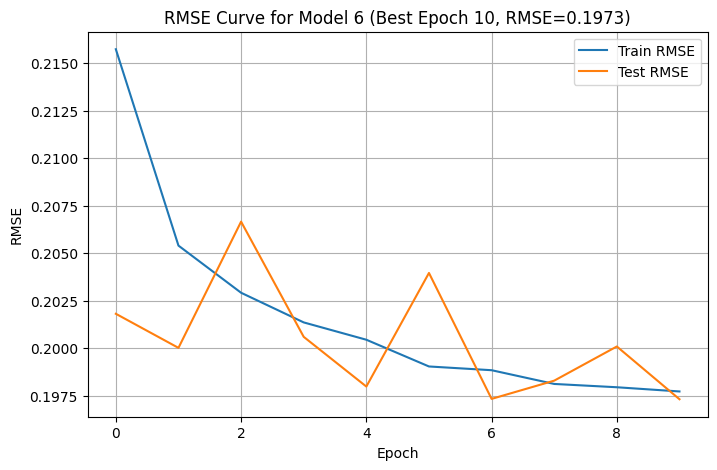

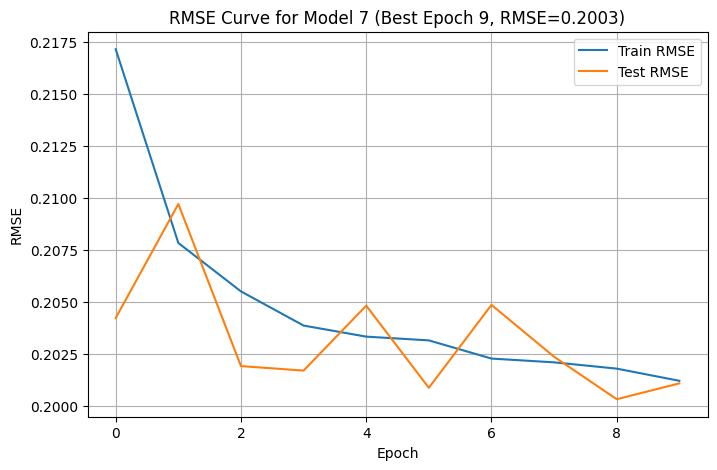

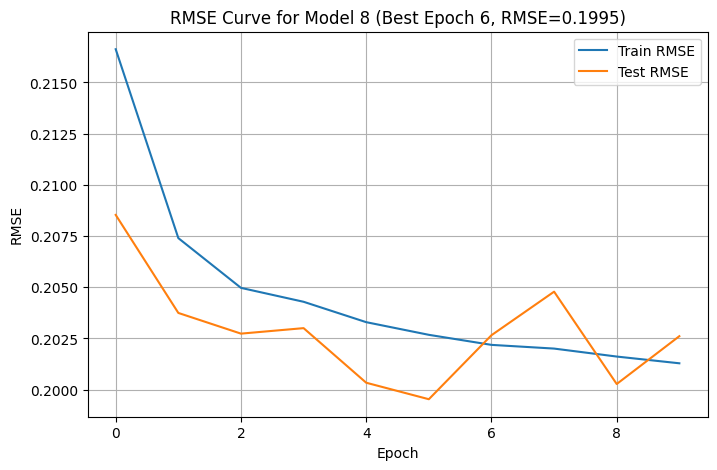

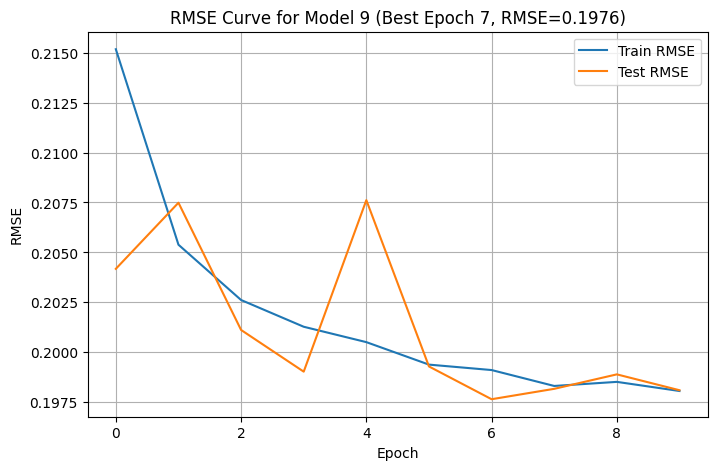

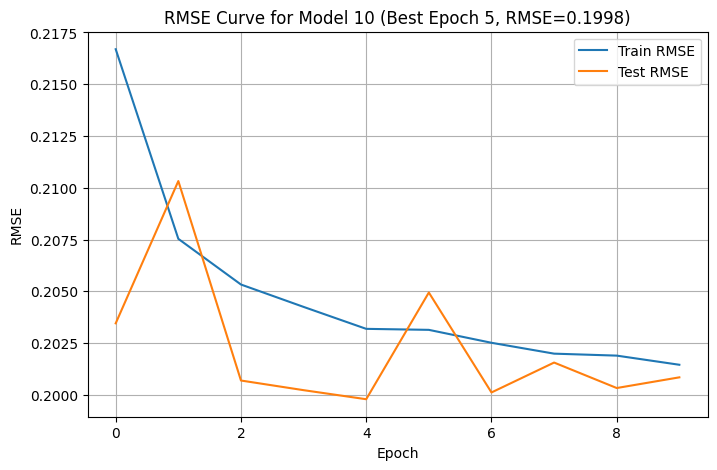

In [46]:
import matplotlib.pyplot as plt

# Plot RMSE curves for each model
for result in all_result:
    model_id = result["model"]
    train_rmses = result["train_rmses"]
    test_rmses = result["test_rmses"]

    plt.figure(figsize=(8, 5))
    plt.plot(train_rmses, label="Train RMSE")
    plt.plot(test_rmses, label="Test RMSE")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title(f"RMSE Curve for Model {model_id} (Best Epoch {result['best_epoch']}, RMSE={result['best_rmse']:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()
